In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
import json
import pandas as pd
import matplotlib.patches as mpatches
from shapely.geometry import Polygon
from matplotlib import pyplot
from shapely.geometry.point import Point
import shapely.affinity
from descartes import PolygonPatch
# Note: download figures.py manually from shapely github repo, put it in shapely install directory
from shapely.figures import SIZE, GREEN, GRAY, set_limits
from shapely.ops import cascaded_union
from shapely.geometry import CAP_STYLE, JOIN_STYLE

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data = pd.io.json.json_normalize(json.loads(open('./data.json').read())["data"])
experiments = pd.io.json.json_normalize(json.loads(open('./experiments.json').read())["data"])
experiments

,color,pres,temp,zone
0,r,"[2.6, 3.3, 3.2, 3.8]","[300, 380, 420, 500]",3
1,g,"[5.5, 4.5, 4.3, 5.6, 5.2, 5.4]","[580, 550, 550, 610, 560, 540]",4
2,b,"[5.6, 5.6, 6.0, 5.3]","[600, 610, 620, 620]",5
3,c,"[5.6, 5.2, 6.0, 6.5, 6.0, 6.3, 6.0, 6.3]","[600, 600, 620, 610, 630, 610, 625, 650]",6
4,m,"[6.2, 6.1, 6.4]","[640, 635, 620]",7


In [4]:
def create_collections():
    poly_coll = []
    col_coll = []
    cent_coll = []
    for poly, color in zip(data.points,data.color):
        poly_coll.append(plt.Polygon(poly))
        col_coll.append(list(map(lambda s: int(s.replace(" ", "")) / 256, color.split(','))))
        cent_coll.append(list(Polygon(poly).centroid.coords)[0])
    return (poly_coll, col_coll, cent_coll)

In [5]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

In [6]:
def plot_polygons(config):
    ells = []
    legend = []
    colls = []
    
    polygons = config['polygons']
    colors = config['colors']
    centers = config['centers']
    names = config['names']
    exp_temp = config['exp_temp']
    exp_pres = config['exp_pres']
    exp_color = config['exp_color']
    exp_zone = config['exp_zone']
    
    fig, ax = plt.subplots(figsize=(20, 10))
    coll = PatchCollection(polygons, facecolor=colors,alpha=0.4,edgecolors=colors,linewidth=4)
    # Make the collection and add it to the plot.
    ax.add_collection(coll)
    for center, name in zip(centers, names): 
        ax.annotate(name,center, horizontalalignment='center',verticalalignment='center')
    ax.set_ylim([0,1.6])
    ax.set_xlim([100,1000])
    
    for x,y,c in zip(exp_temp, exp_pres, exp_color):
        nstd = 2
        y = list(map(lambda i: i/10,y))
        cov = np.cov(x, y)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * nstd * np.sqrt(vals)
        ells.append(((np.mean(x), np.mean(y)), (w/2,h/2),theta))
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color=c, alpha=0.4)
        ell.set_facecolor(c)
        ax.add_artist(ell)
        plt.scatter(x,y,color=c)
    
    for c,z in zip(exp_color, exp_zone):
        legend.append(mpatches.Patch(color=c, label=f'zone {z}'))

    for ell in ells:
        # 1st elem = center point (x,y) coordinates
        # 2nd elem = the two semi-axis values (along x, along y)
        # 3rd elem = angle in degrees between x-axis of the Cartesian base
        #            and the corresponding semi-axis
        ellipse = (ell[0],ell[1],ell[2])
        # Let create a circle of radius 1 around center point:
        circ = shapely.geometry.Point(ellipse[0]).buffer(1)

        # Let create the ellipse along x and y:
        ell  = shapely.affinity.scale(circ, (ellipse[1][0]), (ellipse[1][1]))

        # Let rotate the ellipse (clockwise, x axis pointing right):
        ellr = shapely.affinity.rotate(ell,ellipse[2])
        
        colls.append(ellr)

    union = cascaded_union(colls)
    union = union.simplify(0.2, preserve_topology=True).buffer(0.05)
    xs, ys = union.exterior.xy
    # Make the collection and add it to the plot.
    ax.fill(xs, ys, alpha=0.4, fc='w', ec='none')    
    ax.legend(handles=legend)
    ax.set_ylabel('Pressure, GPa')
    ax.set_xlabel('Temperature, celcus')
    return union


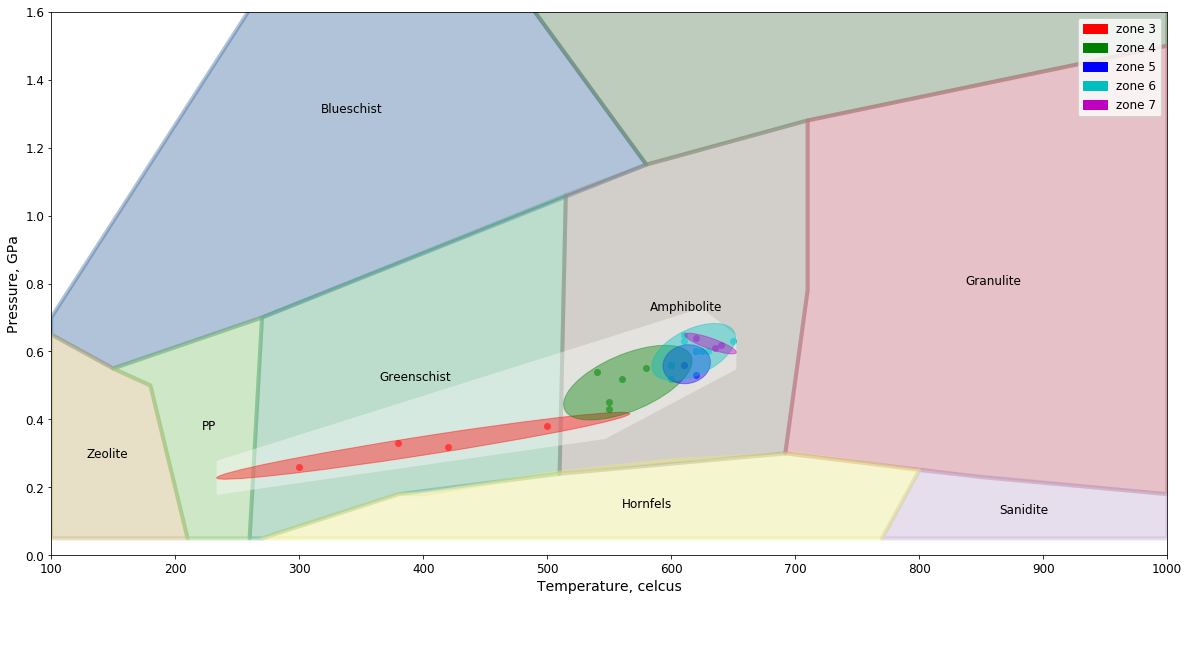

In [12]:
pol, col,cents = create_collections()
config = {
    'polygons': pol,
    'colors'  : col,
    'centers' : cents,
    'names'   : data.name,
    'exp_temp': experiments.temp,
    'exp_pres': experiments.pres,
    'exp_color':experiments.color,
    'exp_zone': experiments.zone
}

focus_area = plot_polygons(config)


In [13]:
#Facie
#ID
#x y pa t ma facie prn

True